# Burstiness Thresholding: HC3 Dataset

This notebook takes the earlier burstiness-thresholding work and applies it to a new dataset, so we can:
- See if the signal-based features we're looking at are more generally useful
- Detect if there is a problem with the Reuters dataset we've been doing the bulk of our work with

In [2]:
import os, glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from fingerprinting_llms.score import LogProbs

HUMAN_LLAMA_ROOT    = 'data/tokens/hc3/human_llama-graded'
LLM_ROOT_LLAMA      = 'data/tokens/hc3/chatgpt_llama-graded'
HUMAN_MIXTRAL_ROOT    = 'data/tokens/hc3/human_mixtral-graded'
LLM_ROOT_MIXTRAL      = 'data/tokens/hc3/chatgpt_mixtral-graded'

RNG = np.random.default_rng(42)


In [3]:
def find_all_npz(root_dir: str) -> list[str]:
    # Recursively find all .npz files under root_dir.
    return sorted(glob.glob(os.path.join(root_dir, '**', '*.npz'), recursive=True))

def load_logp_series_from_root(root_dir: str) -> list[np.ndarray]:
    # Return a list of log-prob arrays (float64) for every .npz file under root_dir.
    # Uses LogProbs.from_file if available, else reads 'token_probs' in the npz.
    paths = find_all_npz(root_dir)
    series = []
    for p in paths:
        if LogProbs is not None:
            lp = LogProbs.from_file(p)
            probs = np.asarray(lp.token_probs, dtype=np.float64)
        else:
            with np.load(p, allow_pickle=True) as npzfile:
                if 'token_probs' in npzfile:
                    probs = np.asarray(npzfile['token_probs'], dtype=np.float64)
                else:
                    raise RuntimeError(f"{p} missing 'token_probs'; cannot load without LogProbs class.")
        #logp = np.log(np.clip(probs, 1e-45, 1.0))
        series.append(probs)
    return series

human_llama_all       = load_logp_series_from_root(HUMAN_LLAMA_ROOT)
llm_series_all_llama   = load_logp_series_from_root(LLM_ROOT_LLAMA)
print(f'Loaded {len(human_llama_all)} human llama-graded docs, '
      f'{len(llm_series_all_llama)} llama-graded docs, ')


human_mixtral_all       = load_logp_series_from_root(HUMAN_MIXTRAL_ROOT)
llm_series_all_mixtral   = load_logp_series_from_root(LLM_ROOT_MIXTRAL)
print(f'Loaded {len(human_mixtral_all)} human mixtral-graded docs, '
      f'{len(llm_series_all_mixtral)} mixtral-graded docs, ')

Loaded 4978 human llama-graded docs, 3787 llama-graded docs, 
Loaded 8022 human mixtral-graded docs, 3787 mixtral-graded docs, 


In [4]:
def rolling_windows(a: np.ndarray, window: int, step: int = 1) -> np.ndarray:
    # Return 2D view of rolling windows over 1D array a (drop partial tail).
    if window < 2 or a.size < window:
        return np.empty((0, window), dtype=a.dtype)
    n = 1 + (a.size - window) // step
    shape = (n, window)
    strides = (a.strides[0]*step, a.strides[0])
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def metric_local_cv_mean(x: np.ndarray, window: int = 64, step: int = 16) -> float:
    # Mean local coefficient of variation across rolling windows.
    # CV = std / |mean| for each window, then averaged.
    w = rolling_windows(x, window, step)
    if w.size == 0:
        return np.nan
    mu = w.mean(axis=1)
    sd = w.std(axis=1, ddof=1)
    denom = np.maximum(np.abs(mu), 1e-8)
    cv = sd / denom
    return float(np.nanmean(cv))

def autocorr_abs_sum(x: np.ndarray, max_lag: int = 50) -> float:
    # Sum of |autocorr(k)| for k=1..max_lag.
    x = np.asarray(x, dtype=np.float64)
    x = x - np.mean(x)
    var = np.var(x)
    if var < 1e-14:
        return 0.0
    s = 0.0
    for k in range(1, max_lag+1):
        num = np.dot(x[:-k], x[k:]) / (x.size - k)
        s += abs(num / var)
    return float(s)

def spectral_entropy(x: np.ndarray) -> float:
    # Entropy of normalized FFT power spectrum, normalized to [0,1].
    x = np.asarray(x, dtype=np.float64)
    x = x - x.mean()
    P = np.abs(np.fft.rfft(x))**2
    total = P.sum()
    if total <= 0:
        return 0.0
    P = P / total
    H = -np.sum(P * np.log(np.clip(P, 1e-45, 1.0)))
    return float(H / np.log(len(P)))

def var_first_diff(x: np.ndarray) -> float:
    # Variance of first difference x[t]-x[t-1].
    x = np.asarray(x, dtype=np.float64)
    if x.size < 2:
        return 0.0
    d = np.diff(x)
    return float(np.var(d))

def pot_rate(x: np.ndarray) -> float:
    # Fraction of tokens below mean-2*std for this doc.
    x = np.asarray(x, dtype=np.float64)
    if x.size == 0:
        return 0.0
    mu = np.mean(x)
    sd = np.std(x, ddof=1) if x.size > 1 else 0.0
    thr = mu - 2.0 * sd
    return float(np.mean(x < thr))

def fano_factor_events(x: np.ndarray, bin_size: int = 64) -> float:
    # Fano factor of bursts across bins. Burst = x[t] < mean-2*std.
    x = np.asarray(x, dtype=np.float64)
    if x.size == 0:
        return 0.0
    mu = np.mean(x)
    sd = np.std(x, ddof=1) if x.size > 1 else 0.0
    thr = mu - 2.0 * sd
    events = (x < thr).astype(np.int32)
    if events.size == 0:
        return 0.0
    n = events.size // bin_size
    if n == 0:
        return 0.0
    b = events[: n*bin_size].reshape(n, bin_size).sum(axis=1)
    m = b.mean()
    v = b.var(ddof=1) if b.size > 1 else 0.0
    return float(v / m) if m > 1e-12 else 0.0

try:
    import pywt  # type: ignore
    HAS_PYWT = True
except Exception:
    HAS_PYWT = False

def wavelet_highfreq_ratio(x: np.ndarray) -> float:
    # High-frequency wavelet energy / total wavelet energy (db4). Fallback: FFT high-band energy ratio.
    x = np.asarray(x, dtype=np.float64)
    x = x - x.mean()
    if HAS_PYWT:
        wavelet = 'db4'
        w = pywt.Wavelet(wavelet)
        max_level = pywt.dwt_max_level(len(x), w.dec_len)
        level = max(1, min(5, max_level))
        coeffs = pywt.wavedec(x, wavelet=w, level=level, mode='symmetric')
        # coeffs[0] = approx, rest = details (high-freq bands)
        e_total = np.sum([np.sum(c*c) for c in coeffs])
        e_high  = np.sum([np.sum(d*d) for d in coeffs[1:]])
        return float(e_high / e_total) if e_total > 0 else 0.0
    # Fallback: FFT split
    X = np.fft.rfft(x)
    P = (np.abs(X)**2)
    if P.sum() <= 0:
        return 0.0
    mid = P.size // 2
    e_total = P.sum()
    e_high = P[mid:].sum()
    return float(e_high / e_total)


In [5]:
def fourier_highfreq_ratio(x: np.ndarray, frac_cut: float = 0.75) -> float:
    # Ratio of energy in the top (1-frac_cut) fraction of FFT frequencies.
    x = np.asarray(x, dtype=np.float64)
    x = x - x.mean()
    X = np.fft.rfft(x)
    P = np.abs(X)**2
    total = P.sum()
    if total <= 0:
        return 0.0
    cut = int(np.floor(frac_cut * P.size))
    high = P[cut:].sum()
    return float(high / total)

def gabor_energy_max(x: np.ndarray, win_len: int = 64, freq_frac: float = 0.25) -> float:
    # Max localized burst energy using a Gabor-like (Gaussian * complex sinusoid) sliding window.
    x = np.asarray(x, dtype=np.float64)
    x = x - x.mean()
    n = win_len
    if x.size < n or n < 4:
        return 0.0
    t = np.arange(n)
    sigma = n / 6.0
    gauss = np.exp(-0.5 * ((t - (n-1)/2)/sigma)**2)
    omega = np.pi * freq_frac  # radians/sample, fraction of Nyquist
    carrier = np.exp(1j * omega * (t - (n-1)/2))
    gabor = gauss * carrier
    energies = []
    for start in range(0, x.size - n + 1):
        seg = x[start:start+n]
        resp = np.vdot(gabor, seg)
        energies.append(np.abs(resp)**2)
    return float(np.max(energies)) if energies else 0.0


In [6]:
def compute_metrics_for_series(logp_list: list[np.ndarray]) -> pd.DataFrame:
    rows = []
    for idx, x in enumerate(logp_list):
        rows.append({
            'doc_id': idx,
            'cv_local_mean':       metric_local_cv_mean(x, window=64, step=16),
            'acf_abs_sum':         autocorr_abs_sum(x, max_lag=50),
            'spectral_entropy':    spectral_entropy(x),
            'var_first_diff':      var_first_diff(x),
            'pot_rate':            pot_rate(x),
            'fano_factor_events':  fano_factor_events(x, bin_size=64),
            'wavelet_hf_ratio':    wavelet_highfreq_ratio(x),
            'fft_high_75':         fourier_highfreq_ratio(x, frac_cut=0.75),
            'fft_high_90':         fourier_highfreq_ratio(x, frac_cut=0.90),
            'gabor_max':           gabor_energy_max(x, win_len=64, freq_frac=0.25),
            'n_tokens':            int(x.size),
        })
    return pd.DataFrame(rows)

# Human vs LLaMA-scored
df_h_llama = compute_metrics_for_series(human_llama_all)
df_h_llama['label'] = 'human'
df_l_llama = compute_metrics_for_series(llm_series_all_llama)
df_l_llama['label'] = 'llm'
df_llama_scored = pd.concat([df_h_llama, df_l_llama], ignore_index=True)

print('llama_scored shape:', df_llama_scored.shape)

# Human vs Mixtral-scored
df_h_mixtral = compute_metrics_for_series(human_mixtral_all)
df_h_mixtral['label'] = 'human'
df_l_mixtral = compute_metrics_for_series(llm_series_all_mixtral)
df_l_mixtral['label'] = 'llm'
df_mixtral_scored = pd.concat([df_h_mixtral, df_l_mixtral], ignore_index=True)

print('mixtral_scored shape:', df_mixtral_scored.shape)


/var/folders/v3/_ft619t917q63j9n5v6t883h000_8v/T/ipykernel_62633/2820223987.py:31: RuntimeWarning: invalid value encountered in scalar divide
  num = np.dot(x[:-k], x[k:]) / (x.size - k)
/opt/anaconda3/envs/llm-fp/lib/python3.12/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 1 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/var/folders/v3/_ft619t917q63j9n5v6t883h000_8v/T/ipykernel_62633/2820223987.py:31: RuntimeWarning: invalid value encountered in scalar divide
  num = np.dot(x[:-k], x[k:]) / (x.size - k)


llama_scored shape: (8765, 13)


/var/folders/v3/_ft619t917q63j9n5v6t883h000_8v/T/ipykernel_62633/2820223987.py:31: RuntimeWarning: invalid value encountered in scalar divide
  num = np.dot(x[:-k], x[k:]) / (x.size - k)
/opt/anaconda3/envs/llm-fp/lib/python3.12/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 1 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/var/folders/v3/_ft619t917q63j9n5v6t883h000_8v/T/ipykernel_62633/2820223987.py:31: RuntimeWarning: invalid value encountered in scalar divide
  num = np.dot(x[:-k], x[k:]) / (x.size - k)


mixtral_scored shape: (11809, 13)


In [7]:
def safe_auroc(y_true, scores):
    # Compute AUROC with guards for degenerate cases.
    try:
        if len(np.unique(y_true)) < 2 or len(np.unique(scores)) < 2:
            return np.nan
        return roc_auc_score(y_true, scores)
    except Exception:
        return np.nan

def evaluate_threshold(metric_values, labels, threshold, direction):
    # Evaluate a fixed threshold on a dataset.
    y_true = (labels == 'human').astype(int)
    x = metric_values.astype(float)
    if direction == '>=':
        y_pred = (x >= threshold).astype(int)
        scores = x
    else:
        y_pred = (x <= threshold).astype(int)
        scores = -x
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    auc  = safe_auroc(y_true, scores)
    cm   = confusion_matrix(y_true, y_pred, labels=[0,1])
    return dict(
        accuracy=acc,
        precision=prec,
        recall=rec,
        f1=f1,
        auroc=auc,
        confusion_matrix=cm,
        y_true=y_true,
        y_pred=y_pred,
    )

def pick_best_threshold(train_vals, train_labels, metric="macro_f1"):
    """
    Find the best (direction, threshold) on the TRAIN SPLIT ONLY.

    metric:
      - "macro_f1": maximize 0.5*(F1_human + F1_llm)
      - "f1_llm":   maximize F1 where llm is the positive class

    Returns a dict with:
      direction, threshold, score, f1_human, f1_llm, macro_f1, degenerate
    """
    x_train = train_vals.astype(float)
    y_train_str = train_labels  # array-like of "human" / "llm"

    # candidate thresholds (same logic as before)
    xs = np.sort(np.unique(x_train))
    if xs.size == 1:
        thr_list = [xs[0] - 1e-9, xs[0], xs[0] + 1e-9]
    else:
        mids = (xs[:-1] + xs[1:]) / 2.0
        thr_list = [xs[0] - 1e-9, *mids, xs[-1] + 1e-9]

    best_non_degenerate = None
    best_any = None  # fallback if everything is degenerate

    for direction in (">=", "<="):
        for thr in thr_list:
            evald = evaluate_threshold(x_train, y_train_str, thr, direction)

            y_true = evald["y_true"]  # 1 = human, 0 = llm
            y_pred = evald["y_pred"]

            # F1s per class
            f1_human = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
            f1_llm   = f1_score(y_true, y_pred, pos_label=0, zero_division=0)
            macro_f1 = 0.5 * (f1_human + f1_llm)

            score = macro_f1 if metric == "macro_f1" else f1_llm

            # Track best_any (even if degenerate)
            cand = {
                "direction": direction,
                "threshold": float(thr),
                "score": score,
                "f1_human": f1_human,
                "f1_llm": f1_llm,
                "macro_f1": macro_f1,
                "degenerate": (len(np.unique(y_pred)) < 2),
            }
            if (best_any is None) or (cand["score"] > best_any["score"]):
                best_any = cand

            # Only consider non-degenerate for preferred result
            if cand["degenerate"]:
                continue
            if (best_non_degenerate is None) or (cand["score"] > best_non_degenerate["score"]):
                best_non_degenerate = cand

    # Prefer a non-degenerate threshold if we found one.
    if best_non_degenerate is not None:
        return best_non_degenerate
    else:
        # Fallback: return best degenerate threshold instead of None.
        # This makes the pipeline not crash, and lets you SEE that it's degenerate.
        return best_any
    
def best_threshold_for_metric(values: np.ndarray, labels: np.ndarray, metric: str="accuracy") -> dict:
    """Find a single threshold to classify 'human' vs 'llm' using one metric.
    Tries both directions:
      - predict human if value >= thr
      - predict human if value <= thr
    Chooses the direction/threshold with the highest accuracy (ties go to first found).
    Returns performance metrics and chosen rule.
    """
    # encode: human=1, llm=0
    y = (labels == "human").astype(int)
    x = values.astype(float)
    # candidate thresholds = midpoints between sorted unique values
    xs = np.sort(np.unique(x))
    if xs.size == 1:
        thr_list = [xs[0]]
    else:
        thr_list = list((xs[:-1] + xs[1:]) / 2.0)
        thr_list = [xs[0] - 1e-9] + thr_list + [xs[-1] + 1e-9]

    best = None
    for direction in (">=", "<="):
        for thr in thr_list:
            if direction == ">=":
                yhat = (x >= thr).astype(int)
            else:
                yhat = (x <= thr).astype(int)
            acc = accuracy_score(y, yhat)
            prec = precision_score(y, yhat, zero_division=0)
            rec  = recall_score(y, yhat, zero_division=0)

            # F1s per class
            f1_human = f1_score(y, yhat, pos_label=1, zero_division=0)
            f1_llm   = f1_score(y, yhat, pos_label=0, zero_division=0)
            macro_f1 = 0.5 * (f1_human + f1_llm)

            f1   = f1_score(y, yhat, zero_division=0)
            cm = confusion_matrix(y, yhat, labels=[0,1])
            result = {
                "direction": direction,
                "threshold": float(thr),
                "accuracy":  float(acc),
                "precision": float(prec),
                "recall":    float(rec),
                "f1_human": f1_human,
                "f1_llm": f1_llm,
                "macro_f1":        float(macro_f1),
                "degenerate": (len(np.unique(yhat)) < 2),
            }
            if (best is None) or (acc > best[metric]):
                best = result
    return best

In [8]:
def stratified_train_val_split(df_in: pd.DataFrame, test_size: float = 0.2, seed: int = 42):
    # Return (train_df, val_df) with stratified split on df_in['label'].
    y = (df_in['label'] == 'human').astype(int).values
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    (train_idx, val_idx) = next(splitter.split(df_in, y))
    return (
        df_in.iloc[train_idx].reset_index(drop=True),
        df_in.iloc[val_idx].reset_index(drop=True),
    )

metrics_to_use = [
    'var_first_diff',
    'cv_local_mean',
    'acf_abs_sum',
    'wavelet_hf_ratio',
    'spectral_entropy',
    'fft_high_75',
    'fft_high_90',
    'gabor_max',
]


In [9]:
train_llama, val_llama = stratified_train_val_split(df_llama_scored, test_size=0.2, seed=42)
rows_llama = []

for m in metrics_to_use:
    # pick best threshold using macro-F1, with degenerate handling
    #picked = pick_best_threshold(
    #metric="macro_f1",
    picked = best_threshold_for_metric(
        train_llama[m].values,
        train_llama["label"].values,
        metric="accuracy",
    )

    # evaluate that fixed threshold on TRAIN (to report train performance)
    train_eval = evaluate_threshold(
        train_llama[m].values,
        train_llama["label"].values,
        picked["threshold"],
        picked["direction"],
    )

    # evaluate that fixed threshold on VAL (held-out)
    val_eval = evaluate_threshold(
        val_llama[m].values,
        val_llama["label"].values,
        picked["threshold"],
        picked["direction"],
    )

    # compute per-class F1 on TRAIN to line up with what pick_best_threshold optimized
    f1_human_train = f1_score(train_eval["y_true"], train_eval["y_pred"], pos_label=1, zero_division=0)
    f1_llm_train   = f1_score(train_eval["y_true"], train_eval["y_pred"], pos_label=0, zero_division=0)
    macro_f1_train = 0.5 * (f1_human_train + f1_llm_train)

    # same for VAL, so we can see generalization
    f1_human_val = f1_score(val_eval["y_true"], val_eval["y_pred"], pos_label=1, zero_division=0)
    f1_llm_val   = f1_score(val_eval["y_true"], val_eval["y_pred"], pos_label=0, zero_division=0)
    macro_f1_val = 0.5 * (f1_human_val + f1_llm_val)

    rows_llama.append({
        "metric": m,
        "direction": picked["direction"],
        "threshold": picked["threshold"],
        "degenerate_thresh": picked["degenerate"],  # True means it basically guessed one class

        # TRAIN metrics
        "train_accuracy": train_eval["accuracy"],
        "train_precision": train_eval["precision"],
        "train_recall": train_eval["recall"],
        "train_f1_overall": train_eval["f1"],
        "train_f1_human": f1_human_train,
        "train_f1_llm": f1_llm_train,
        "train_macro_f1": macro_f1_train,
        "train_auroc": train_eval["auroc"],

        # VAL metrics
        "val_accuracy": val_eval["accuracy"],
        "val_precision": val_eval["precision"],
        "val_recall": val_eval["recall"],
        "val_f1_overall": val_eval["f1"],
        "val_f1_human": f1_human_val,
        "val_f1_llm": f1_llm_val,
        "val_macro_f1": macro_f1_val,
        "val_auroc": val_eval["auroc"],
    })

results_llama = (
    pd.DataFrame(rows_llama)
    .sort_values(["val_macro_f1", "val_accuracy"], ascending=False)
    .reset_index(drop=True)
)

results_llama


,metric,direction,threshold,degenerate_thresh,train_accuracy,train_precision,train_recall,train_f1_overall,train_f1_human,train_f1_llm,train_macro_f1,train_auroc,val_accuracy,val_precision,val_recall,val_f1_overall,val_f1_human,val_f1_llm,val_macro_f1,val_auroc
0,var_first_diff,>=,6.081888,False,0.972476,0.984899,0.966349,0.975536,0.975536,0.968541,0.972038,0.983546,0.975471,0.989723,0.966867,0.978162,0.978162,0.972023,0.975092,0.985045
1,cv_local_mean,<=,1.249332,False,0.825014,0.963649,0.718985,0.823529,0.823529,0.826474,0.825002,NaN,0.816315,0.955405,0.709839,0.814516,0.814516,0.818079,0.816298,NaN
2,wavelet_hf_ratio,>=,0.394515,False,0.812179,0.877586,0.777750,0.824657,0.824657,0.797789,0.811223,0.893651,0.805476,0.876870,0.765060,0.817158,0.817158,0.792200,0.804679,0.894874
3,gabor_max,>=,196.542643,False,0.706503,0.815617,0.624309,0.707255,0.707255,0.705748,0.706501,0.683272,0.708500,0.822903,0.620482,0.707499,0.707499,0.709494,0.708496,0.682045
4,fft_high_75,>=,0.212010,False,0.596977,0.649046,0.632094,0.640458,0.640458,0.541531,0.590995,0.616084,0.585282,0.640838,0.614458,0.627371,0.627371,0.532476,0.579923,0.616282
5,spectral_entropy,<=,0.891618,False,0.581004,0.813702,0.340030,0.479632,0.479632,0.649320,0.564476,0.582549,0.596121,0.854680,0.348394,0.495007,0.495007,0.663498,0.579253,0.598232
6,acf_abs_sum,>=,3.489438,False,0.555619,0.794558,0.293320,0.428467,0.428467,0.636491,0.532479,NaN,0.541358,0.779070,0.269076,0.400000,0.400000,0.628809,0.514404,NaN
7,fft_high_90,>=,0.000006,True,0.567884,0.567884,1.000000,0.724395,0.724395,0.000000,0.362198,0.568446,0.568169,0.568169,1.000000,0.724627,0.724627,0.000000,0.362314,0.575320


## Results
These val_macro_f1 results are a bit incredibe, actually.  I've included previous results with the Reuters dataset for reference (see below), but here are current:
```
	metric	direction	threshold	val_macro_f1
0	var_first_diff	>=	6.081888	0.975092
1	cv_local_mean	<=	1.249332	0.816298
2	wavelet_hf_ratio	>=	0.394515	0.804679
3	gabor_max	>=	196.542643	0.708496
4	fft_high_75	>=	0.212010	0.579923
5	spectral_entropy	<=	0.891618	0.579253
6	acf_abs_sum	>=	3.489438	0.514404
7	fft_high_90	>=	0.000006	0.362314
```

## Previous Reuters 5050 Results -- HGMG vs LGMG
```
metric	direction	        threshold	val_macro_f1
0.	cv_local_mean	<=	1.297705	0.736246
1.	acf_abs_sum	<=	    1.895999	0.728879
2.	var_first_diff	>=	   8.179554	    0.662598
3.	spectral_entropy	>=	  0.920281	    0.648359
4.	gabor_max	>=	326.328455	False	0.612144
5.	fft_high_75	>=	0.220113	False	0.559147
6.	fft_high_90	>=	0.078723	False	0.554489
7.	wavelet_hf_ratio	>=	0.504157	0.512860
```
## Previous Reuters 5050 Results -- HGLG vs MGLG
```
	metric	    direction	threshold	val_macro_f1
0	wavelet_hf_ratio	>=	0.445807	0.853184
1	cv_local_mean	<=	1.244405	0.660772
2	acf_abs_sum	<=	2.420992	0.592337
3	gabor_max	>=	258.642148	0.562561
4	var_first_diff	>=	8.137711	0.525621
5	fft_high_75	>=	0.176674	0.447965
6	spectral_entropy	>=	0.886641	0.436318
7	fft_high_90	>=	0.059076	0.434500
```

### Interpretation of Threshold Results

- The variation of first difference VAR[E[(token1 - token2) for all sequential tokens]] separates our human from LLM text almost perfectly
- The coefficient of variation and Wavelet HF ratio both do well
- Gabor Energy Max  (“how big is the strongest little wave burst at this frequency?”) does okay
- The remainder of features are not very predictive


[LLAMA-GRADED] Metric: var_first_diff
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[747  10]
 [ 33 963]]


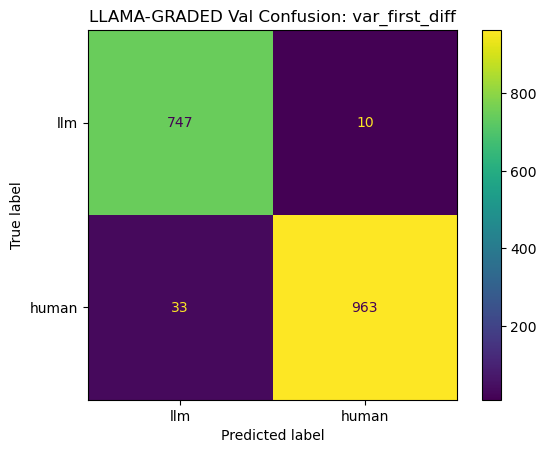


[LLAMA-GRADED] Metric: cv_local_mean
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[724  33]
 [289 707]]


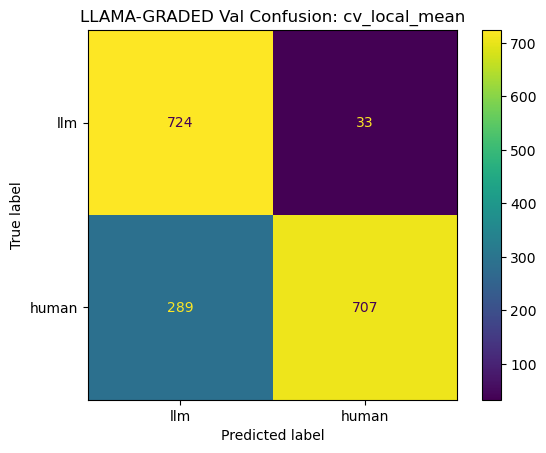


[LLAMA-GRADED] Metric: wavelet_hf_ratio
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[650 107]
 [234 762]]


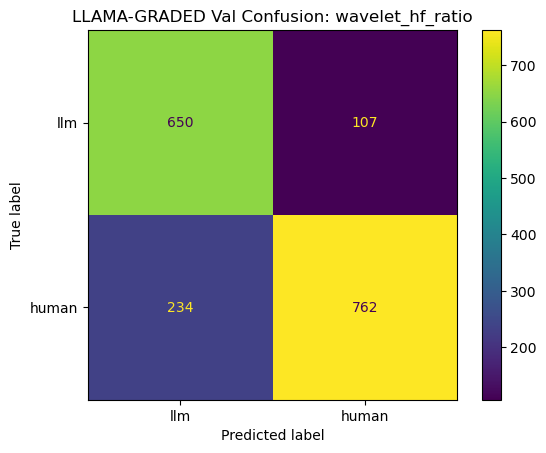


[LLAMA-GRADED] Metric: gabor_max
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[624 133]
 [378 618]]


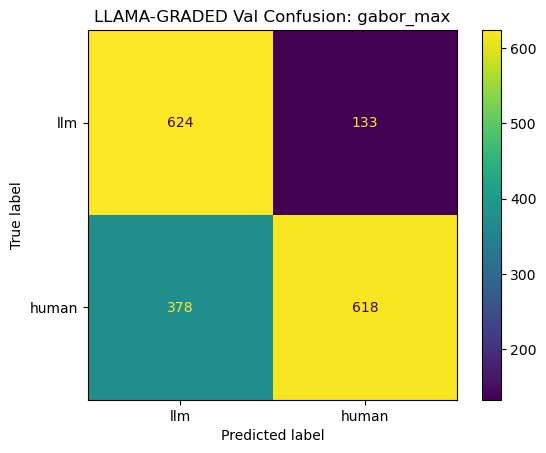


[LLAMA-GRADED] Metric: fft_high_75
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[414 343]
 [384 612]]


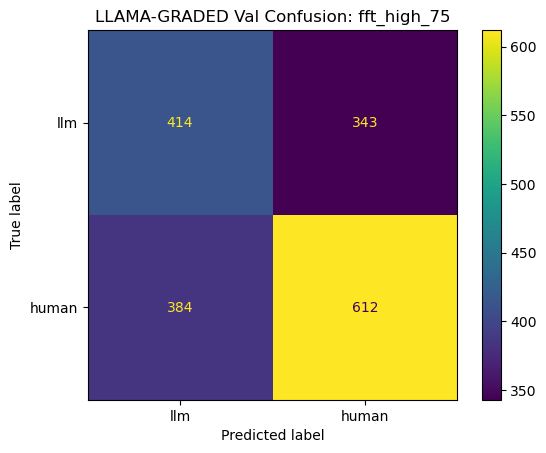


[LLAMA-GRADED] Metric: spectral_entropy
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[698  59]
 [649 347]]


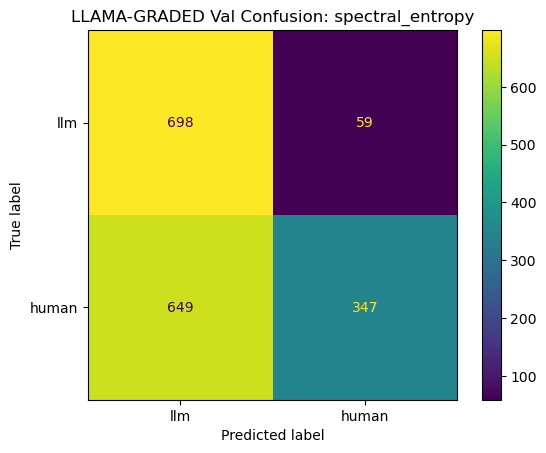


[LLAMA-GRADED] Metric: acf_abs_sum
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[681  76]
 [728 268]]


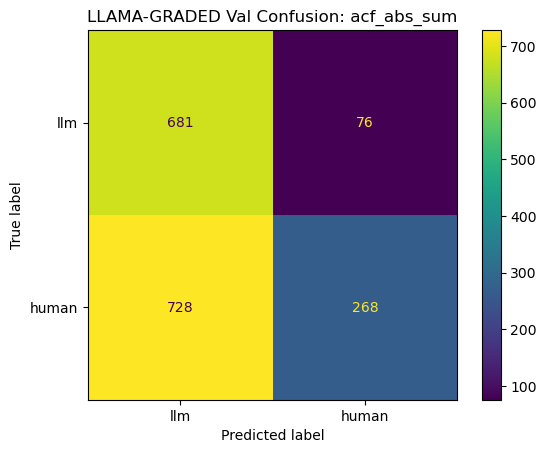


[LLAMA-GRADED] Metric: fft_high_90
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[  0 757]
 [  0 996]]


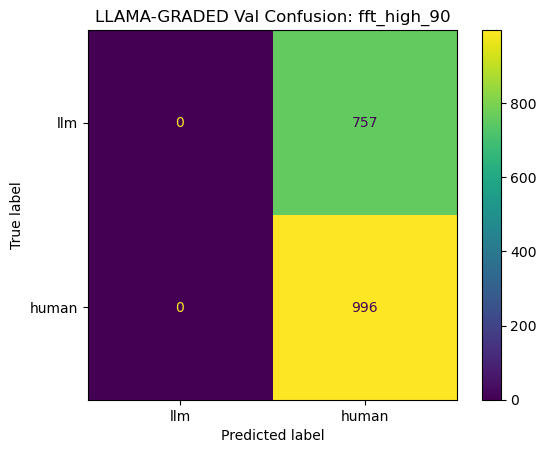

In [10]:
for i, row in results_llama.iterrows():
    m = row['metric']
    picked_dir = row['direction']
    thr = row['threshold']
    val_eval = evaluate_threshold(
        val_llama[m].values,
        val_llama['label'].values,
        thr,
        picked_dir,
    )
    cm = val_eval['confusion_matrix']
    print(f"\n[LLAMA-GRADED] Metric: {m}")
    print('Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])')
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['llm','human'])
    disp.plot(values_format='d')
    plt.title(f'LLAMA-GRADED Val Confusion: {m}')
    plt.show()


## Random Forest Classifier
Let's mash all of these thresholds up as features in a RFC

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

features = [
    'var_first_diff',
    'cv_local_mean',
    'acf_abs_sum',
    'wavelet_hf_ratio',
    'spectral_entropy',
    'fft_high_75',
    'fft_high_90',
    'gabor_max',
]
# === Build X/y for training and validation ===
le = LabelEncoder()
le.fit(train_llama["label"])  # should map {"llm":0, "human":1}, but we won't assume — we'll use le.classes_

X_train = train_llama[features].values
y_train = le.transform(train_llama["label"].values)

X_val = val_llama[features].values
y_val = le.transform(val_llama["label"].values)

print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Label mapping: {'human': np.int64(0), 'llm': np.int64(1)}


In [12]:
# === Define the model ===
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1,
)

# === Cross-validation on the TRAIN split only ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro",
    "f1_macro": "f1_macro",
}

cv_results = cross_validate(
    rf,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_estimator=False,
    n_jobs=-1,
)

print("Cross-validated (train split) performance:")
print(f"  accuracy:       {cv_results['test_accuracy'].mean():.3f} ± {cv_results['test_accuracy'].std():.3f}")
print(f"  precision_macro:{cv_results['test_precision_macro'].mean():.3f} ± {cv_results['test_precision_macro'].std():.3f}")
print(f"  recall_macro:   {cv_results['test_recall_macro'].mean():.3f} ± {cv_results['test_recall_macro'].std():.3f}")
print(f"  f1_macro:       {cv_results['test_f1_macro'].mean():.3f} ± {cv_results['test_f1_macro'].std():.3f}")

# === Fit final model on ALL training data ===
rf.fit(X_train, y_train)

Cross-validated (train split) performance:
  accuracy:       0.986 ± 0.004
  precision_macro:0.985 ± 0.004
  recall_macro:   0.986 ± 0.004
  f1_macro:       0.985 ± 0.004


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [13]:
# === Validation predictions ===
y_val_pred = rf.predict(X_val)
y_val_proba = rf.predict_proba(X_val)[:, 1]  # probability of class "1" (should correspond to 'human')

val_accuracy  = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average="binary", zero_division=0)
val_recall    = recall_score(y_val, y_val_pred, average="binary", zero_division=0)
val_f1        = f1_score(y_val, y_val_pred, average="binary", zero_division=0)

# macro scores treat human and llm symmetrically:
val_precision_macro = precision_score(y_val, y_val_pred, average="macro", zero_division=0)
val_recall_macro    = recall_score(y_val, y_val_pred, average="macro", zero_division=0)
val_f1_macro        = f1_score(y_val, y_val_pred, average="macro", zero_division=0)

# AUROC (for human vs llm). We need to be careful: roc_auc_score expects scores for the "1" class.
try:
    val_auroc = roc_auc_score(y_val, y_val_proba)
except ValueError:
    val_auroc = np.nan  # happens if only one class present

print("Validation performance (held-out):")
print(f"  accuracy:         {val_accuracy:.3f}")
print(f"  precision (bin):  {val_precision:.3f}")
print(f"  recall (bin):     {val_recall:.3f}")
print(f"  f1 (bin):         {val_f1:.3f}")
print(f"  precision_macro:  {val_precision_macro:.3f}")
print(f"  recall_macro:     {val_recall_macro:.3f}")
print(f"  f1_macro:         {val_f1_macro:.3f}")
print(f"  AUROC (human=1):  {val_auroc:.3f}")

Validation performance (held-out):
  accuracy:         0.987
  precision (bin):  0.978
  recall (bin):     0.993
  f1 (bin):         0.986
  precision_macro:  0.986
  recall_macro:     0.988
  f1_macro:         0.987
  AUROC (human=1):  0.999


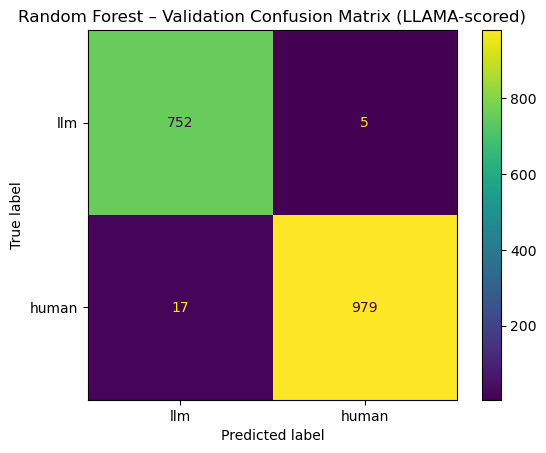

Confusion matrix rows = true class [llm, human], cols = predicted [llm, human]:
[[752   5]
 [ 17 979]]


In [14]:
cm = confusion_matrix(y_val, y_val_pred, labels=[le.transform(["llm"])[0], le.transform(["human"])[0]])
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["llm", "human"],
)
disp.plot(values_format="d")
plt.title("Random Forest – Validation Confusion Matrix (LLAMA-scored)")
plt.show()

print("Confusion matrix rows = true class [llm, human], cols = predicted [llm, human]:")
print(cm)

## <p color="red">Okay, let's do the Mixtral-Graded documents now</p>

In [15]:
train_mix, val_mix = stratified_train_val_split(df_mixtral_scored, test_size=0.2, seed=42)
rows_mix = []

for m in metrics_to_use:
    # pick best threshold using macro-F1, with degenerate handling
    #picked = pick_best_threshold(
    #metric="macro_f1",
    picked = best_threshold_for_metric(
        train_mix[m].values,
        train_mix["label"].values,
        metric="accuracy",
    )

    # evaluate that fixed threshold on TRAIN (to report train performance)
    train_eval = evaluate_threshold(
        train_mix[m].values,
        train_mix["label"].values,
        picked["threshold"],
        picked["direction"],
    )

    # evaluate that fixed threshold on VAL (held-out)
    val_eval = evaluate_threshold(
        val_mix[m].values,
        val_mix["label"].values,
        picked["threshold"],
        picked["direction"],
    )

    # compute per-class F1 on TRAIN to line up with what pick_best_threshold optimized
    f1_human_train = f1_score(train_eval["y_true"], train_eval["y_pred"], pos_label=1, zero_division=0)
    f1_llm_train   = f1_score(train_eval["y_true"], train_eval["y_pred"], pos_label=0, zero_division=0)
    macro_f1_train = 0.5 * (f1_human_train + f1_llm_train)

    # same for VAL, so we can see generalization
    f1_human_val = f1_score(val_eval["y_true"], val_eval["y_pred"], pos_label=1, zero_division=0)
    f1_llm_val   = f1_score(val_eval["y_true"], val_eval["y_pred"], pos_label=0, zero_division=0)
    macro_f1_val = 0.5 * (f1_human_val + f1_llm_val)

    rows_mix.append({
        "metric": m,
        "direction": picked["direction"],
        "threshold": picked["threshold"],
        "degenerate_thresh": picked["degenerate"],  # True means it basically guessed one class

        # TRAIN metrics
        "train_accuracy": train_eval["accuracy"],
        "train_precision": train_eval["precision"],
        "train_recall": train_eval["recall"],
        "train_f1_overall": train_eval["f1"],
        "train_f1_human": f1_human_train,
        "train_f1_llm": f1_llm_train,
        "train_macro_f1": macro_f1_train,
        "train_auroc": train_eval["auroc"],

        # VAL metrics
        "val_accuracy": val_eval["accuracy"],
        "val_precision": val_eval["precision"],
        "val_recall": val_eval["recall"],
        "val_f1_overall": val_eval["f1"],
        "val_f1_human": f1_human_val,
        "val_f1_llm": f1_llm_val,
        "val_macro_f1": macro_f1_val,
        "val_auroc": val_eval["auroc"],
    })

results_mix = (
    pd.DataFrame(rows_mix)
    .sort_values(["val_macro_f1", "val_accuracy"], ascending=False)
    .reset_index(drop=True)
)

results_mix


,metric,direction,threshold,degenerate_thresh,train_accuracy,train_precision,train_recall,train_f1_overall,train_f1_human,train_f1_llm,train_macro_f1,train_auroc,val_accuracy,val_precision,val_recall,val_f1_overall,val_f1_human,val_f1_llm,val_macro_f1,val_auroc
0,var_first_diff,>=,8.020952,False,0.914576,0.937734,0.936419,0.937076,0.937076,0.867029,0.902053,0.955207,0.920406,0.941433,0.941433,0.941433,0.941433,0.875826,0.908629,0.961748
1,cv_local_mean,<=,1.483338,False,0.847994,0.991902,0.782609,0.874913,0.874913,0.806312,0.840613,NaN,0.847163,0.993651,0.780062,0.873997,0.873997,0.805810,0.839903,NaN
2,wavelet_hf_ratio,>=,0.327217,False,0.726051,0.788807,0.814867,0.801625,0.801625,0.557456,0.679540,0.782037,0.712532,0.779927,0.803738,0.791654,0.791654,0.536519,0.664086,0.770609
3,spectral_entropy,<=,0.944123,False,0.679369,0.679335,1.000000,0.809053,0.809053,0.000660,0.404856,0.663971,0.679509,0.679509,1.000000,0.809176,0.809176,0.000000,0.404588,0.688390
4,fft_high_75,>=,0.006911,True,0.679263,0.679263,1.000000,0.809002,0.809002,0.000000,0.404501,0.477145,0.679509,0.679509,1.000000,0.809176,0.809176,0.000000,0.404588,0.502853
5,fft_high_90,>=,0.000034,True,0.679263,0.679263,1.000000,0.809002,0.809002,0.000000,0.404501,0.491617,0.679509,0.679509,1.000000,0.809176,0.809176,0.000000,0.404588,0.513840
6,gabor_max,<=,1464.120764,False,0.679475,0.679483,0.999688,0.809055,0.809055,0.002635,0.405845,0.481388,0.679509,0.679509,1.000000,0.809176,0.809176,0.000000,0.404588,0.488864
7,acf_abs_sum,>=,0.663972,False,0.582301,0.644995,0.856475,0.735841,0.735841,0.002528,0.369185,NaN,0.580017,0.644100,0.853583,0.734191,0.734191,0.000000,0.367095,NaN


## Results
It is interesting that:
- The results are less strong than the llama-graded corpus
- The general shape of the results is very similar

## Previous Reuters 5050 Results -- HGMG vs LGMG
```
metric	direction	        threshold	val_macro_f1
0.	cv_local_mean	<=	1.297705	0.736246
1.	acf_abs_sum	<=	    1.895999	0.728879
2.	var_first_diff	>=	   8.179554	    0.662598
3.	spectral_entropy	>=	  0.920281	    0.648359
4.	gabor_max	>=	326.328455	False	0.612144
5.	fft_high_75	>=	0.220113	False	0.559147
6.	fft_high_90	>=	0.078723	False	0.554489
7.	wavelet_hf_ratio	>=	0.504157	0.512860
```
## Previous Reuters 5050 Results -- HGLG vs MGLG
```
	metric	    direction	threshold	val_macro_f1
0	wavelet_hf_ratio	>=	0.445807	0.853184
1	cv_local_mean	<=	1.244405	0.660772
2	acf_abs_sum	<=	2.420992	0.592337
3	gabor_max	>=	258.642148	0.562561
4	var_first_diff	>=	8.137711	0.525621
5	fft_high_75	>=	0.176674	0.447965
6	spectral_entropy	>=	0.886641	0.436318
7	fft_high_90	>=	0.059076	0.434500
```


[Mixtral-GRADED] Metric: var_first_diff
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[ 663   94]
 [  94 1511]]


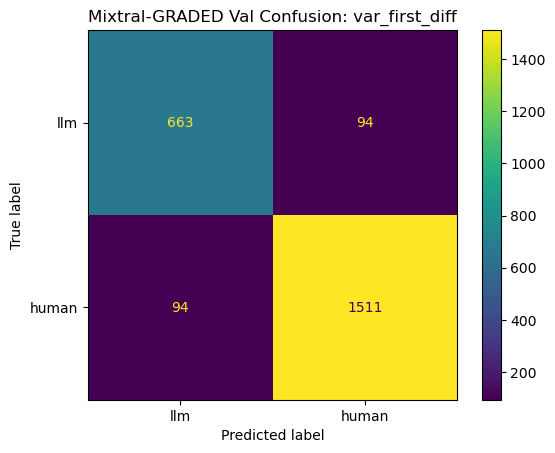


[Mixtral-GRADED] Metric: cv_local_mean
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[ 749    8]
 [ 353 1252]]


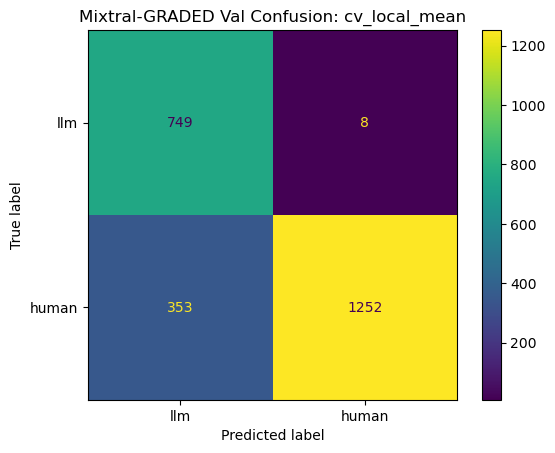


[Mixtral-GRADED] Metric: wavelet_hf_ratio
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[ 393  364]
 [ 315 1290]]


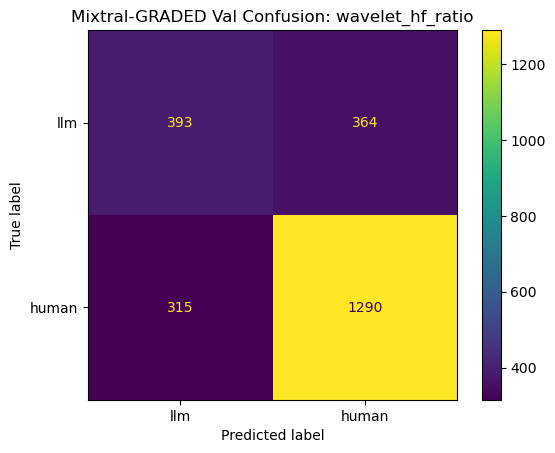


[Mixtral-GRADED] Metric: spectral_entropy
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[   0  757]
 [   0 1605]]


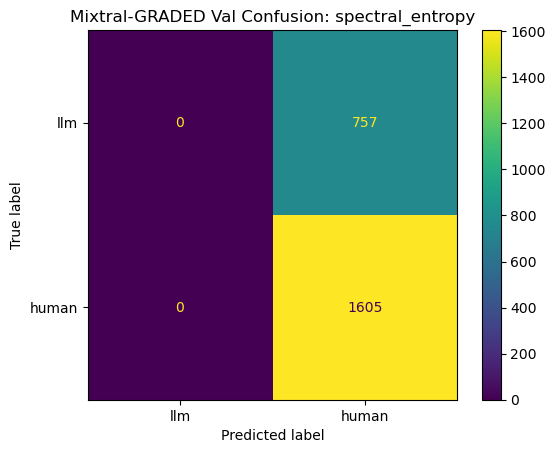


[Mixtral-GRADED] Metric: fft_high_75
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[   0  757]
 [   0 1605]]


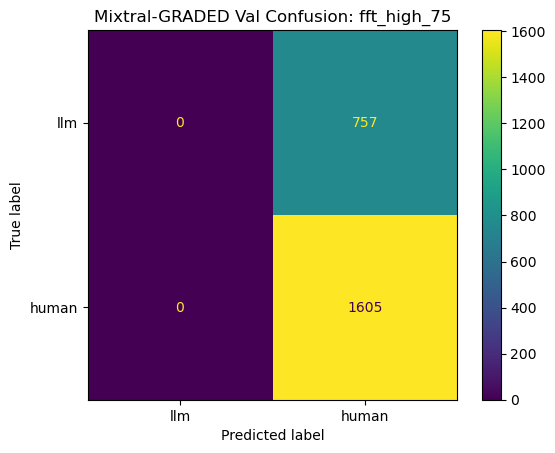


[Mixtral-GRADED] Metric: fft_high_90
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[   0  757]
 [   0 1605]]


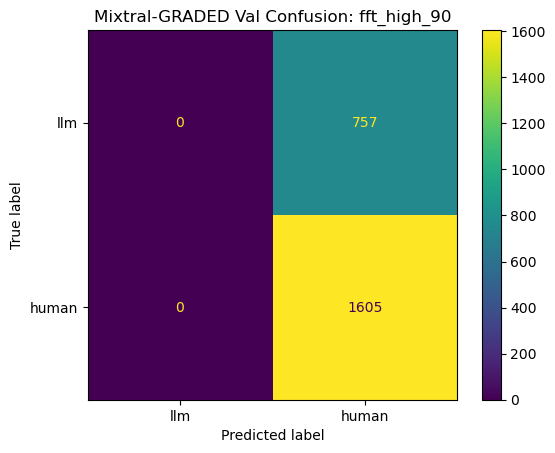


[Mixtral-GRADED] Metric: gabor_max
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[   0  757]
 [   0 1605]]


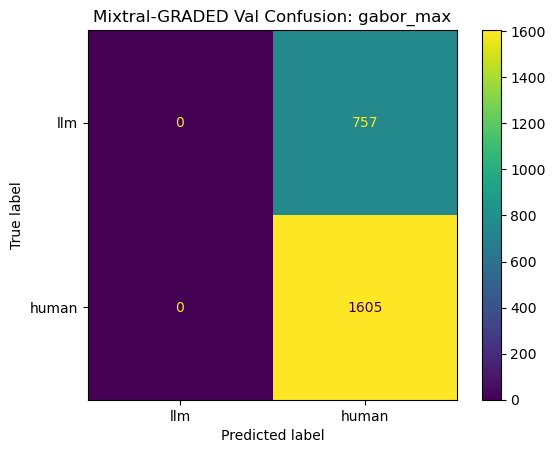


[Mixtral-GRADED] Metric: acf_abs_sum
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[   0  757]
 [ 235 1370]]


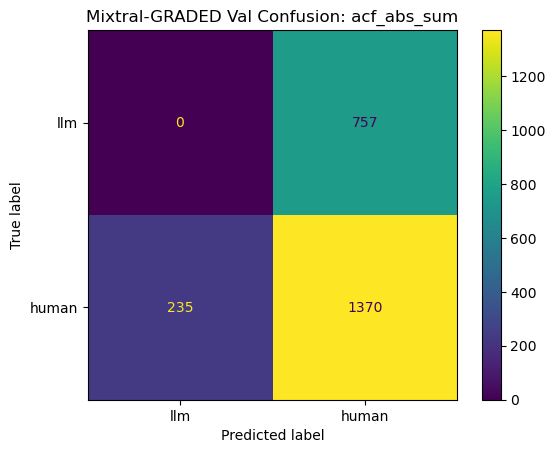

In [16]:
for i, row in results_mix.iterrows():
    m = row['metric']
    picked_dir = row['direction']
    thr = row['threshold']
    val_eval = evaluate_threshold(
        val_mix[m].values,
        val_mix['label'].values,
        thr,
        picked_dir,
    )
    cm = val_eval['confusion_matrix']
    print(f"\n[Mixtral-GRADED] Metric: {m}")
    print('Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])')
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['llm','human'])
    disp.plot(values_format='d')
    plt.title(f'Mixtral-GRADED Val Confusion: {m}')
    plt.show()


## Random Forest Classifier
Let's mash all of these thresholds up as features in a RFC

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

features = [
    'var_first_diff',
    'cv_local_mean',
    'acf_abs_sum',
    'wavelet_hf_ratio',
    'spectral_entropy',
    'fft_high_75',
    'fft_high_90',
    'gabor_max',
]
# === Build X/y for training and validation ===
le = LabelEncoder()
le.fit(train_mix["label"])  # should map {"llm":0, "human":1}, but we won't assume — we'll use le.classes_

X_train = train_mix[features].values
y_train = le.transform(train_mix["label"].values)

X_val = val_mix[features].values
y_val = le.transform(val_mix["label"].values)

print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Label mapping: {'human': np.int64(0), 'llm': np.int64(1)}


In [18]:
# === Define the model ===
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1,
)

# === Cross-validation on the TRAIN split only ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro",
    "f1_macro": "f1_macro",
}

cv_results = cross_validate(
    rf,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_estimator=False,
    n_jobs=-1,
)

print("Cross-validated (train split) performance:")
print(f"  accuracy:       {cv_results['test_accuracy'].mean():.3f} ± {cv_results['test_accuracy'].std():.3f}")
print(f"  precision_macro:{cv_results['test_precision_macro'].mean():.3f} ± {cv_results['test_precision_macro'].std():.3f}")
print(f"  recall_macro:   {cv_results['test_recall_macro'].mean():.3f} ± {cv_results['test_recall_macro'].std():.3f}")
print(f"  f1_macro:       {cv_results['test_f1_macro'].mean():.3f} ± {cv_results['test_f1_macro'].std():.3f}")

# === Fit final model on ALL training data ===
rf.fit(X_train, y_train)

Cross-validated (train split) performance:
  accuracy:       0.988 ± 0.003
  precision_macro:0.984 ± 0.005
  recall_macro:   0.989 ± 0.003
  f1_macro:       0.986 ± 0.004


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [19]:
# === Validation predictions ===
y_val_pred = rf.predict(X_val)
y_val_proba = rf.predict_proba(X_val)[:, 1]  # probability of class "1" (should correspond to 'human')

val_accuracy  = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average="binary", zero_division=0)
val_recall    = recall_score(y_val, y_val_pred, average="binary", zero_division=0)
val_f1        = f1_score(y_val, y_val_pred, average="binary", zero_division=0)

# macro scores treat human and llm symmetrically:
val_precision_macro = precision_score(y_val, y_val_pred, average="macro", zero_division=0)
val_recall_macro    = recall_score(y_val, y_val_pred, average="macro", zero_division=0)
val_f1_macro        = f1_score(y_val, y_val_pred, average="macro", zero_division=0)

# AUROC (for human vs llm). We need to be careful: roc_auc_score expects scores for the "1" class.
try:
    val_auroc = roc_auc_score(y_val, y_val_proba)
except ValueError:
    val_auroc = np.nan  # happens if only one class present

print("Validation performance (held-out):")
print(f"  accuracy:         {val_accuracy:.3f}")
print(f"  precision (bin):  {val_precision:.3f}")
print(f"  recall (bin):     {val_recall:.3f}")
print(f"  f1 (bin):         {val_f1:.3f}")
print(f"  precision_macro:  {val_precision_macro:.3f}")
print(f"  recall_macro:     {val_recall_macro:.3f}")
print(f"  f1_macro:         {val_f1_macro:.3f}")
print(f"  AUROC (human=1):  {val_auroc:.3f}")

Validation performance (held-out):
  accuracy:         0.990
  precision (bin):  0.979
  recall (bin):     0.989
  f1 (bin):         0.984
  precision_macro:  0.987
  recall_macro:     0.990
  f1_macro:         0.988
  AUROC (human=1):  0.999


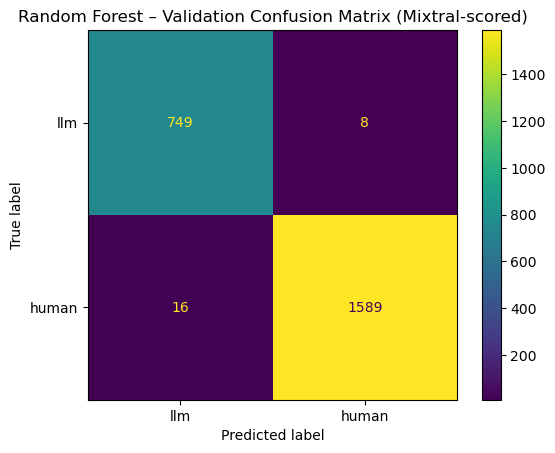

Confusion matrix rows = true class [llm, human], cols = predicted [llm, human]:
[[ 749    8]
 [  16 1589]]


In [20]:
cm = confusion_matrix(y_val, y_val_pred, labels=[le.transform(["llm"])[0], le.transform(["human"])[0]])
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["llm", "human"],
)
disp.plot(values_format="d")
plt.title("Random Forest – Validation Confusion Matrix (Mixtral-scored)")
plt.show()

print("Confusion matrix rows = true class [llm, human], cols = predicted [llm, human]:")
print(cm)